Author: [**Ariel Rokem**](http://arokem.org), [**The University of Washington eScience Institute**](http://escience.washington.edu)

### Calculate with your data

We've already seen that we can make some simple calculations, using `numpy`. Here, we will extend this a bit, using another library: `scipy` contains implementations of a variety of useful scientific computing tools, such as optimization routines, statistical distributions and statistical functions, implementations of image processing algorithms, and signal processing routines. Here, we will focus on signal processing, to build a deeper understanding of the fMRI signals we have visualized in previous parts.

In [1]:
import numpy as np
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
img = nib.load('./data/run1.nii.gz')
data = img.get_data()
mpl.style.use('bmh')

### Let's look at that data again

In particular, notice that there is a fair amount of noise. 

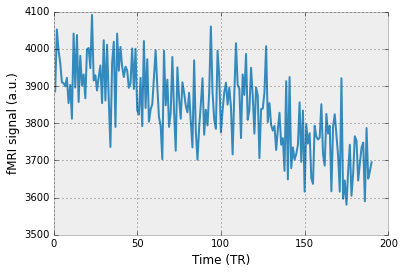

In [2]:
fig, ax = plt.subplots(1)
ax.plot(data[32, 32, 15])
ax.set_xlabel('Time (TR)')
ax.set_ylabel('fMRI signal (a.u.)')

Given that the TR was 2.4 seconds, some of the fluctuations are way too fast to be hemodynamic in origin. On the other hand, there is a large overall drift in the signal that is also unlikely to be of physiological interest in analyzing the functional responses in this experiment. Hacking means that you don't just observe this kind of thing without diving a little bit deeper. In the following notebook, we will hack these aspects of the signal using signal processing tools from the `scipy` package.

#### `scipy.fftpack` is used for basic spectral decomposition of the signal:

This module includes implementations of the Fast Fourier Transform algorithm, and related algorithms.

In [2]:
import scipy

In [3]:
scipy?

In [4]:
import scipy.fftpack as fft

In [5]:
# We'll calculate some quantitites related to sampling:
TR = 2.4 # We know this from the Lambertz-Deheane et al. papers
sampling_rate = 1 / TR # The sampling rate is 1/TR
Nyquist_freq = sampling_rate / 2 # The Nyquist frequency is the highest frequency we can determine: half of the samping rate
freq_bands = np.linspace(0, Nyquist_freq, data.shape[-1] / 2 + 1) # The length of the signal determines the bandwidth uncertainty

In [6]:
freq_bands

array([ 0.        ,  0.00219298,  0.00438596,  0.00657895,  0.00877193,
        0.01096491,  0.01315789,  0.01535088,  0.01754386,  0.01973684,
        0.02192982,  0.02412281,  0.02631579,  0.02850877,  0.03070175,
        0.03289474,  0.03508772,  0.0372807 ,  0.03947368,  0.04166667,
        0.04385965,  0.04605263,  0.04824561,  0.0504386 ,  0.05263158,
        0.05482456,  0.05701754,  0.05921053,  0.06140351,  0.06359649,
        0.06578947,  0.06798246,  0.07017544,  0.07236842,  0.0745614 ,
        0.07675439,  0.07894737,  0.08114035,  0.08333333,  0.08552632,
        0.0877193 ,  0.08991228,  0.09210526,  0.09429825,  0.09649123,
        0.09868421,  0.10087719,  0.10307018,  0.10526316,  0.10745614,
        0.10964912,  0.11184211,  0.11403509,  0.11622807,  0.11842105,
        0.12061404,  0.12280702,  0.125     ,  0.12719298,  0.12938596,
        0.13157895,  0.13377193,  0.13596491,  0.13815789,  0.14035088,
        0.14254386,  0.14473684,  0.14692982,  0.14912281,  0.15

### The Fourier Transform 

![Fourier](./images/fourier.png)

Importantly, for real-valued signal, the complex part of the FT and the real part are duplicates of each other, so we'll only need to look at one side of this

In [7]:
fft.fft?

In [14]:
f_data1 = fft.fft(data)
f_data1.shape

(64, 64, 30, 191)

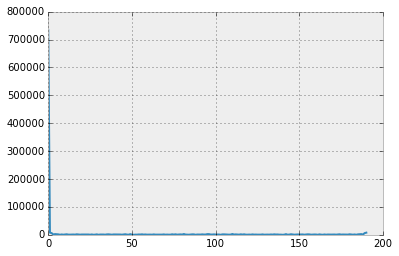

In [13]:
plt.plot(np.abs(f_data1[32,32,15]))

In [15]:
f_data = f_data1[..., :data.shape[-1]/2 + 1]

The power is the magnitude, or absolute value of the complex-valued FT:

In [16]:
p_data = np.abs(f_data)

In [17]:
freqs = np.linspace(0, Nyquist_freq, data.shape[-1]/2 + 1)

In [18]:
p_data.shape

(64, 64, 30, 96)

In [19]:
freqs.shape

(96,)

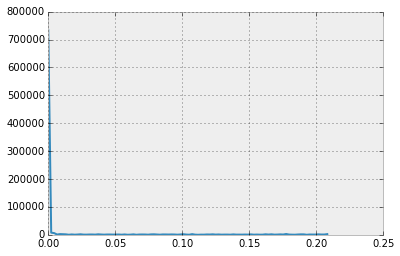

In [20]:
fig, ax = plt.subplots(1)
ax.plot(freqs, p_data[32, 32, 15])

The first prominent peak represents the vertical offset in the signal (sometimes called the 'DC component'). For us to see anything here, we need to remember that the signal had a non-zero mean, but ditch that part and only plot parts of the power spectrum related to the frequency bands of interest (1 and above):

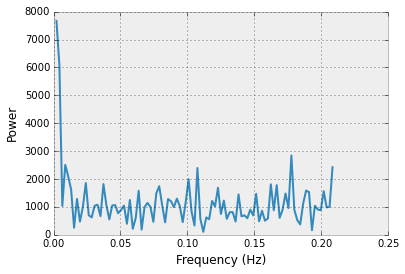

In [21]:
fig, ax = plt.subplots(1)
ax.plot(freqs[1:], p_data[32, 32, 15][1:])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')

This power spectral density (or PSD), tells us how much of the overall variance or power in the signal is represented in each one of the frequency bands. Here, we can clearly see that there is significant amounts of power at some very low frequency (the prominent peak in the first few bands), and some significant amount of power at high frequencies. The low frequency fluctuations are probably related to the overall drift in the signal. Since the hemodynamic response is thought to have a slow characteristics, fluctuations of the signal at frequencies above 0.15 Hz (or so) are unlikely to be related to this signal, and are likely to be noise from other sources: other physiological sources (such as subject motion), and fluctuations in the instrument itself. Let's see if we can do something about this.

#### `scipy.signal` is used for signal processing

Next, we will use the `scipy.signal` module to process the signal, and eliminate these noise elements.

In [22]:
import scipy.signal as sps

A rather easy thing to do upfront is to remove linear trends from the signal. This is equivalent to finding the best-fit line through the data and substracting that line from the data. We'll do that for all of the data, and then look at the results for the middle voxel:

In [23]:
sps.detrend?

In [24]:
detrend_data = sps.detrend(data)

In [25]:
detrend_data_power = np.abs(fft.fft(detrend_data))[32, 32, 15][:data.shape[-1]/2 + 1]

In [26]:
detrend_data_power.shape

(96,)

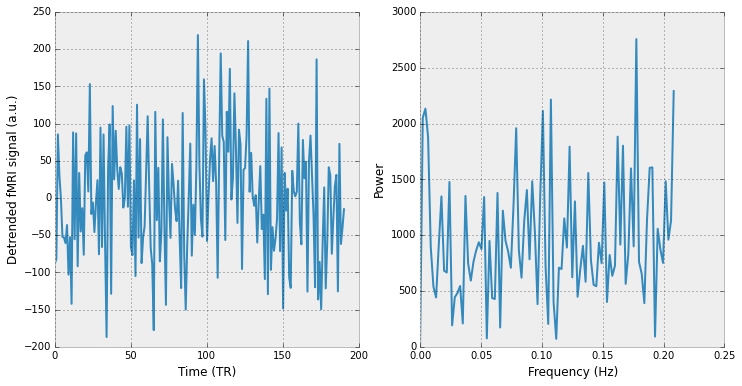

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(detrend_data[32, 32, 15])
ax[0].set_xlabel('Time (TR)')
ax[0].set_ylabel('Detrended fMRI signal (a.u.)')
ax[1].plot(freqs, detrend_data_power)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power')
fig.set_size_inches([12, 6])

A few things to note about the detrended signal and its spectrum: 

- The signal is now zero mean. This is also reflected in the fact that the DC component of the PSD is 0. 
- The linear trend is entirely gone and the lower frequencies in the spectrum are substantially attenuated
- There is still some power in some low frequencies, related to non-linear drift, and there is still substantial power in highe frequencies. 

Another approach to processing the signal is a filtering approach. Next, we will design a digital filter and apply it to this siqnal.

A typical filter to use for this kind of thing is a [Finite Impulse Response](XXX ) filter with a Hamming windowing function

In [27]:
filter_order = 16
n_coefficients = filter_order + 1
ub = 0.15
lb = 0.00001
ub_frac = ub / Nyquist_freq
lb_frac = lb / Nyquist_freq
# This returns the numerator ('b') polynomial coefficients needed for filtering. For the denominator, we'll use 1:
b_ub = sps.firwin(n_coefficients, ub_frac, window='hamming')
filtered_data = sps.filtfilt(b_ub, [1], data)

In [28]:
filtered_data_power = np.abs(fft.fft(filtered_data))[..., :data.shape[-1]/2 + 1]

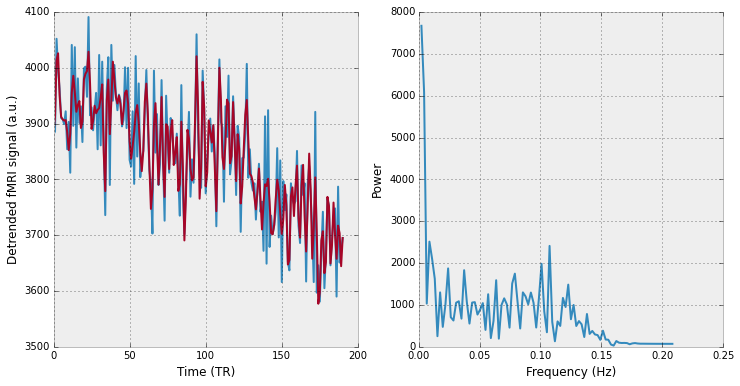

In [29]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(data[32, 32, 15])
ax[0].plot(filtered_data[32, 32, 15])
ax[0].set_xlabel('Time (TR)')
ax[0].set_ylabel('Detrended fMRI signal (a.u.)')
ax[1].plot(freqs[1:], filtered_data_power[32, 32, 15][1:])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power')
fig.set_size_inches([12, 6])

In [30]:
# This is a bit of a song and dance, to apply a spectral inversion:
b_lb = -1 * sps.firwin(n_coefficients, lb_frac, window='hamming') # All coefficients need to be negative
b_lb[(n_coefficients + 1) / 2] = b_lb[(n_coefficients + 1) / 2] + 1 # Except this one!
filtered_data = sps.filtfilt(-1 * b_lb, [1], filtered_data)

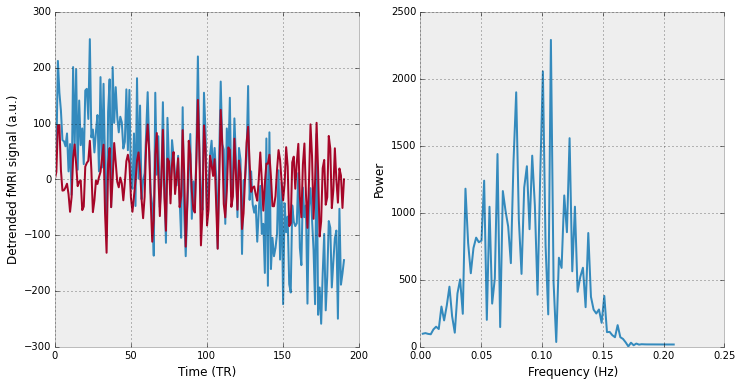

In [31]:
filtered_data_power = np.abs(fft.fft(filtered_data))[..., :data.shape[-1]/2 + 1]
fig, ax = plt.subplots(1, 2)
ax[0].plot(data[32, 32, 15] - np.mean(data[32, 32, 15]))
ax[0].plot(filtered_data[32, 32, 15])
ax[0].set_xlabel('Time (TR)')
ax[0].set_ylabel('Detrended fMRI signal (a.u.)')
ax[1].plot(freqs[1:], filtered_data_power[32, 32, 15][1:])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power')
fig.set_size_inches([12, 6])